# **Analyzing Customer Churn for a Telecom Company**

## **Table of Contents**

* [Introduction](#introduction)
* [Exploratory Data Analysis](#exploration-data-analysis)
* [Data Cleaning](#data-cleaning)
* [Feature Engineering](#feature-engineering)
* [Model building](#model-building)
* [Conclusions and Recommandations](#conclusions-and-recommandations)

#### **Objective**

This project is about churn analysis for a telecom company. We will dive deep into both Supervised learning and Unsupervised learning methods to uncover the hidden patterns of customer churn. We will not only detect when customers are likely to leave but alsothe key factors driving their decisions.

#### **The dataset**

The dataset has been taken on Kaggle. It has some variables :
* **General customer information** (customerID, gender, etc.) 
* **Services provided to the customer** (InternetService, OnlineSecurity, StreamingTV, etc.)
* **Subscription information** (nature of the contract, payment method, monthly charges, etc.)
* **Churn state** (a variable that tells if a defined customer churned or not)

For a more detailed description of the dataset, you can click on the following link : [Telco Customer Churn
](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

<a id="introduction"></a>

## **1. Introduction**

### **1.1. Import the required libraries**

In [6]:
# Manipulation and Visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

# Modeling libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score

### **1.2. Load the data**

In [8]:
churn_df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
churn_df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [9]:
churn_df.shape

(7043, 21)

There are 7043 instances with 21 attributes in the dataset. Each instance represents the state of one client.

Let's get a quick description of the data.

In [12]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


On the 21 attributes, we have 3 numerical (int / float) columns and 18 categorical (object) columns. Based on the description of the different variables provided by Kaggle, all of the types seem to be good. Nevertheless, we have some exceptions : 

* The **TotalCharges** variable is supposed to be numeric because we are talking about amounts of money. There are certainly some object values in the TotalCharges column.
* The **SeniorCitizen** variable is in fact a binary variable and then a categorical one. The fact it is in a numerical form means it is already encoded.

By looking at non-null count, we can also notice there are no missing values in the dataset. 

<a id="exploration-data-analysis"></a>

## **2. Exploratory Data Analysis**

Before going to the analysis, we should split the data into train and test splits. Test set must be always be separated of the training to avoid *data snooping bias*. But as we should not enough data, we will split data later.

Each of the variables we detected earlier should have an appropriate type. Then, we should treat them. The goal here is not to do the preprocessing but to "standardize" the data to make the exploration phase easy.

**Conversion of the variable TotalCharges to float type**

In [18]:
num_list, str_list = [], []
for value in churn_df["TotalCharges"]:
    try:
        num_value = float(value)
        num_list.append(num_value)
    except:
        num_list.append(None)
        str_list.append(value)

churn_df["TotalCharges"] = pd.Series(num_list)

In [19]:
str_list

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

We can notice all of the string values containing in this column are the space characters.

**Identification of numerical and categorical variables**

We will assign each variable to the appropriate list.

In [23]:
numerical_cols = [col for col in churn_df.columns if churn_df[col].dtype in ["int64", "float64"]]
numerical_cols.remove("SeniorCitizen")
numerical_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [24]:
categorical_cols = [col for col in churn_df.columns if churn_df[col].dtype == "object"]
categorical_cols.remove("customerID")
categorical_cols.remove("Churn")
categorical_cols.append("SeniorCitizen")
categorical_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

In [25]:
target_col = ["Churn"]

### **2.1. Univariate Analysis**

#### **2.1.3. Distribution of the target variable (Churn)**

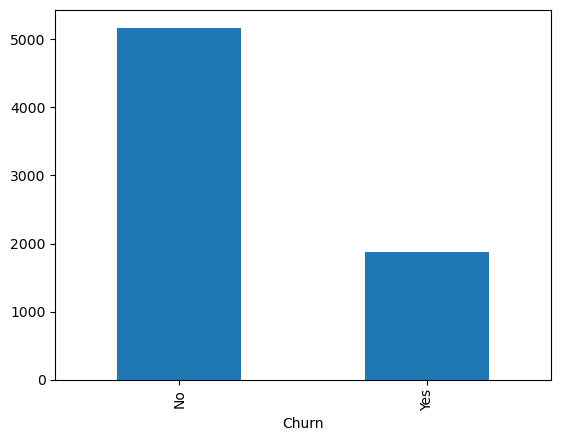

In [28]:
churn_df[target_col[0]].value_counts().plot(kind="bar")
plt.show()

Our target variable *Churn* is very unbalanced. We have less customer that churned than customers that didn't churned. It may suggest, a priori, a good customer management by the structure or a notable absence of cases of churn.

#### **2.1.4. Distributions of numerical variables**

In [31]:
churn_df[numerical_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


Looking at these statistics, we notice a few things:
* The median tenure at the Telecom company is 29 months (2 years and 5 months)
* Total charges seem to be very large compared to the Monthly charges

Let's take a look at the distributions of the different variables.

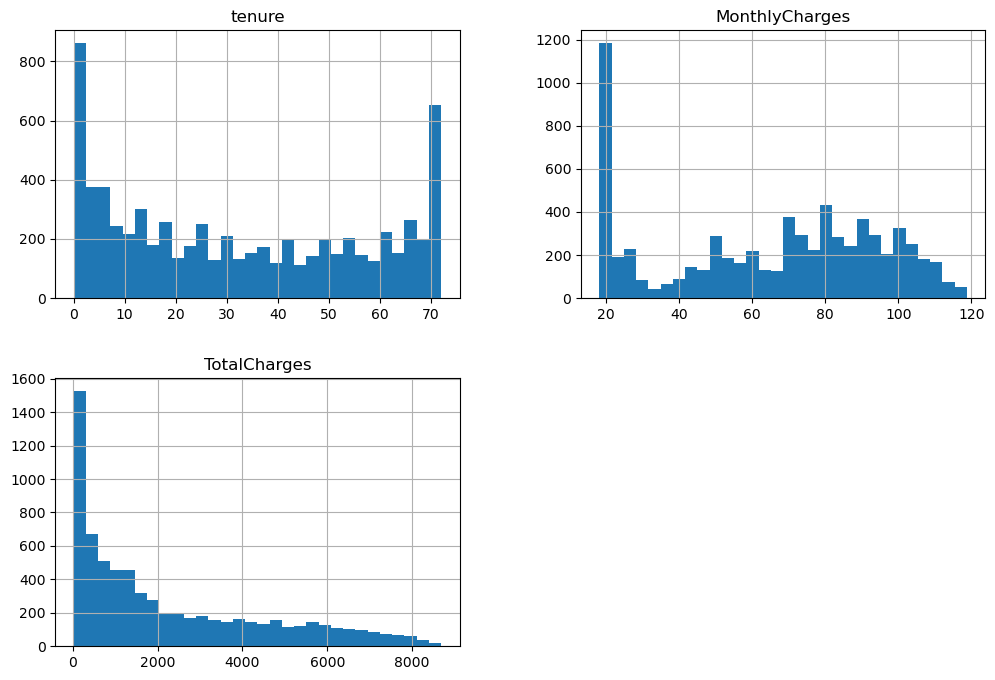

In [34]:
churn_df[numerical_cols].hist(bins=30, figsize=(12, 8))
plt.show()

None of the distributions is normal. In the case of TotalCharges, we have even a **right-skewed** distribution.

#### **2.1.5. Distributions of categorical variables**

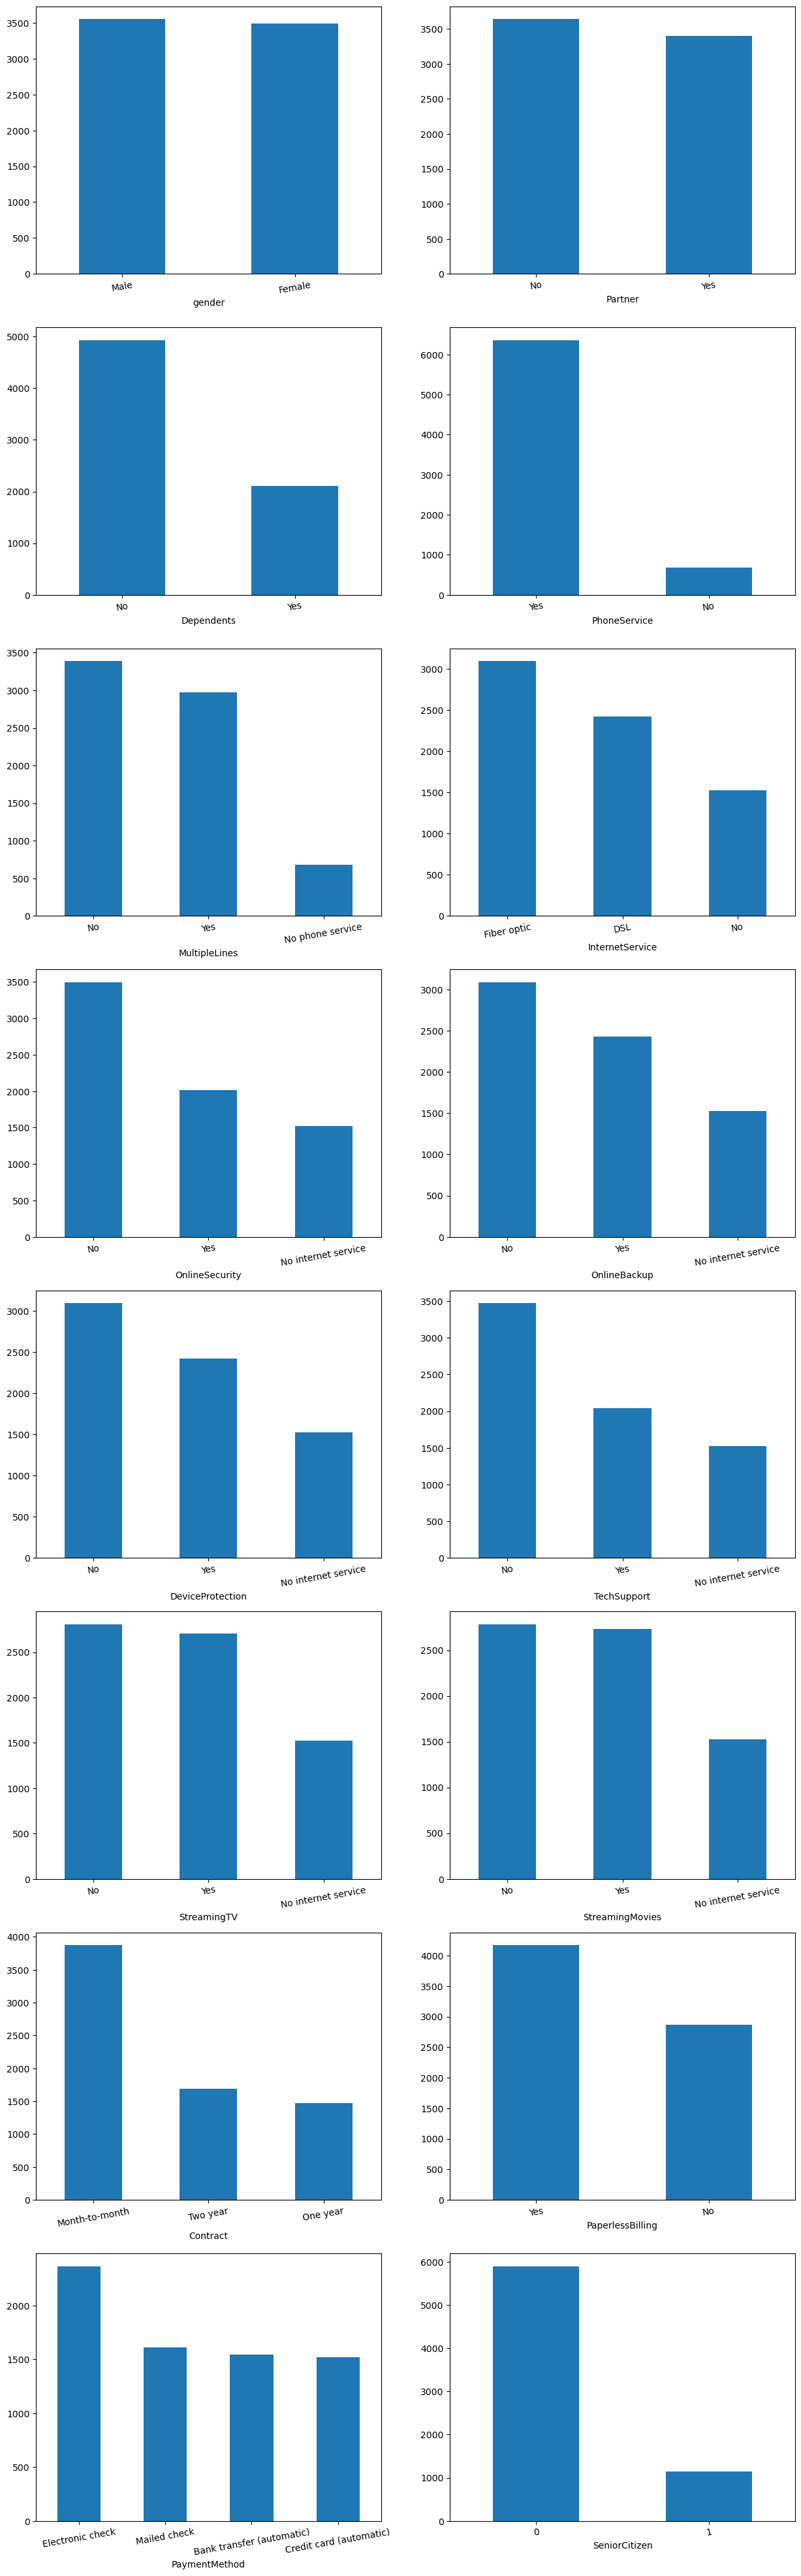

In [37]:
pos = None
num_rows, num_cols = sum(divmod(len(categorical_cols), 2)), 2
fig, axes = plt.subplots(num_rows, num_cols)
fig.set_size_inches((15, 50))

for i, col in enumerate(categorical_cols):
    pos = divmod(i, 2)
    churn_df[col].value_counts().plot(kind="bar", ax=axes[pos[0], pos[1]])
    for tick in axes[pos[0], pos[1]].get_xticklabels():
        tick.set_rotation(10)

plt.show()

We can observe the following :

* Each of the categorical variables have between 2 and 4 classes.
* The *Gender* and *Partner* variables are (almost) evenly distributed.
* There are *very few senior citizen* in the dataset.
* Customers generally prefer Month-to-month contract.
* Internet Service seems to be linked to many variables (six actually). It can be a factor of *some correlations* later.

### **2.2. Bivariate and Multivariate Analysis**

#### **2.2.1. Analysis of repartitions**

We will start by displaying the contingency tables between the categorical variables and the Churn variable.

In [42]:
for col in categorical_cols:
    display(pd.crosstab(churn_df[col], churn_df[target_col[0]], normalize=True))

Churn,No,Yes
gender,,
Female,0.36192,0.133324
Male,0.37271,0.132046


Churn,No,Yes
Partner,,
No,0.346585,0.170382
Yes,0.388045,0.094988


Churn,No,Yes
Dependents,,
No,0.481329,0.219083
Yes,0.253301,0.046287


Churn,No,Yes
PhoneService,,
No,0.072696,0.024137
Yes,0.661934,0.241232


Churn,No,Yes
MultipleLines,,
No,0.360784,0.120545
No phone service,0.072696,0.024137
Yes,0.301150,0.120687


Churn,No,Yes
InternetService,,
DSL,0.278574,0.065171
Fiber optic,0.255431,0.184154
No,0.200625,0.016044


Churn,No,Yes
OnlineSecurity,,
No,0.289223,0.207440
No internet service,0.200625,0.016044
Yes,0.244782,0.041886


Churn,No,Yes
OnlineBackup,,
No,0.263382,0.175067
No internet service,0.200625,0.016044
Yes,0.270623,0.074258


Churn,No,Yes
DeviceProtection,,
No,0.267500,0.171944
No internet service,0.200625,0.016044
Yes,0.266506,0.077382


Churn,No,Yes
TechSupport,,
No,0.287803,0.205310
No internet service,0.200625,0.016044
Yes,0.246202,0.044015


Churn,No,Yes
StreamingTV,,
No,0.265228,0.133750
No internet service,0.200625,0.016044
Yes,0.268778,0.115576


Churn,No,Yes
StreamingMovies,,
No,0.262246,0.133182
No internet service,0.200625,0.016044
Yes,0.271759,0.116144


Churn,No,Yes
Contract,,
Month-to-month,0.315207,0.234985
One year,0.185574,0.023570
Two year,0.233849,0.006815


Churn,No,Yes
PaperlessBilling,,
No,0.34119,0.066591
Yes,0.39344,0.198779


Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),0.182593,0.036632
Credit card (automatic),0.183161,0.032941
Electronic check,0.183729,0.152066
Mailed check,0.185148,0.043731


Churn,No,Yes
SeniorCitizen,,
0,0.640068,0.197785
1,0.094562,0.067585


When we observed the various contigency tables, we can notice, they have more no churn cases than yes churn cases like the churn variables. Also, the variables *SeniorCitizen* and *PhoneService* seem to be particularly interesting because we can detect a high frequency of no churn for citizens who are not senior and a high score of no churn for people who have the phone service. Nevertheless, we can't draw direct conclusions because the data in these variables are imbalanced as shown in the univariate analysis.

We detect earlier that some variables have *InternetService* in common. Let's see if they are correlated.

In [45]:
internet_cols = [col for col in churn_df if "No internet service" in churn_df[col].unique()]
internet_cols

['OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [46]:
for col in internet_cols:
    display(pd.crosstab(churn_df[col], churn_df["InternetService"], normalize=True))

InternetService,DSL,Fiber optic,No
OnlineSecurity,,,
No,0.176203,0.320460,0.000000
No internet service,0.000000,0.000000,0.216669
Yes,0.167542,0.119125,0.000000


InternetService,DSL,Fiber optic,No
OnlineBackup,,,
No,0.189550,0.248900,0.000000
No internet service,0.000000,0.000000,0.216669
Yes,0.154196,0.190686,0.000000


InternetService,DSL,Fiber optic,No
DeviceProtection,,,
No,0.192532,0.246912,0.000000
No internet service,0.000000,0.000000,0.216669
Yes,0.151214,0.192674,0.000000


InternetService,DSL,Fiber optic,No
TechSupport,,,
No,0.176487,0.316626,0.000000
No internet service,0.000000,0.000000,0.216669
Yes,0.167258,0.122959,0.000000


InternetService,DSL,Fiber optic,No
StreamingTV,,,
No,0.207866,0.191112,0.000000
No internet service,0.000000,0.000000,0.216669
Yes,0.135880,0.248474,0.000000


InternetService,DSL,Fiber optic,No
StreamingMovies,,,
No,0.204458,0.190970,0.000000
No internet service,0.000000,0.000000,0.216669
Yes,0.139287,0.248616,0.000000


We don't notice a specific event here.

Finally, we will take a look at the distributions of churn for each numerical variable

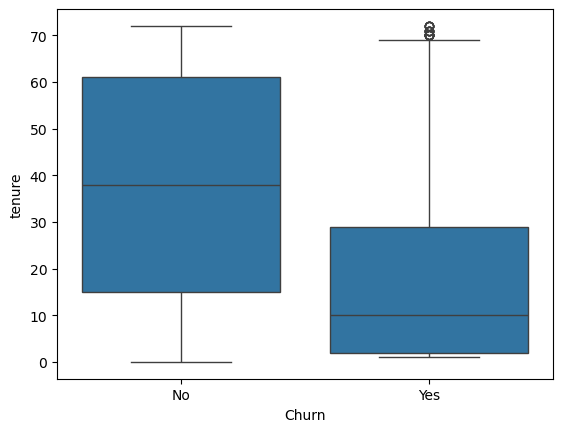

In [49]:
# Churn with tenure

sns.boxplot(data=churn_df, x="Churn", y="tenure")
plt.show()

By analyzing the two boxplots, we can see that the people who churn are those who have been with the company for a short time, compared to those who do not churn.

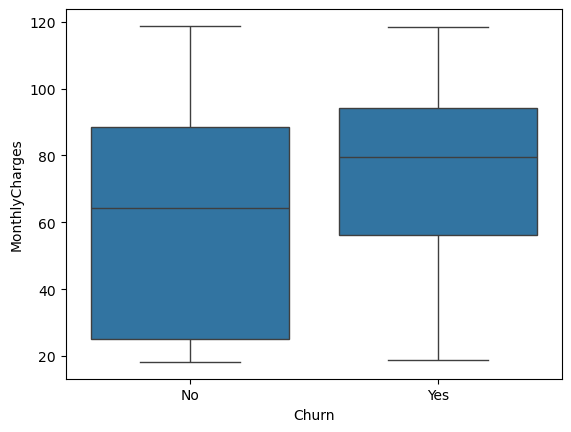

In [51]:
# Churn with MonthlyCharges

sns.boxplot(data=churn_df, x="Churn", y="MonthlyCharges")
plt.show()

In [52]:
# To do

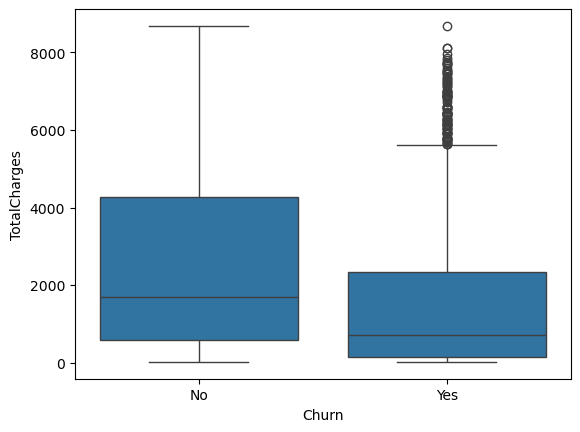

In [53]:
# Churn with TotalCharges

sns.boxplot(data=churn_df, x="Churn", y="TotalCharges")
plt.show()

In [54]:
# To do

#### **2.2.2. Correlation analysis**

Let's take a look the correlation between the numerical variables.

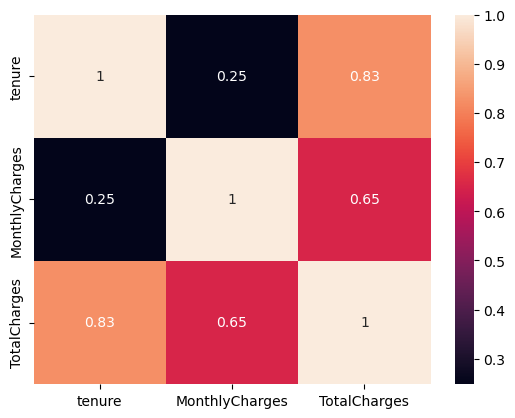

In [57]:
sns.heatmap(churn_df[numerical_cols].corr(), annot=True)
plt.show()

We can observe the tenure is strongly correlated to the total charges.

<a id="data-cleaning"></a>

## **3. Data Cleaning**

Before the cleaning process, we will split our data in train and test sets.

In [61]:
y = churn_df["Churn"]
X = churn_df.drop(columns=["Churn"])

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We will drop the customerID variables from the two sets. As we will probably use them later, we will store them before the dropping.

In [64]:
# Storage
customerID_train = X_train["customerID"]
customerID_test = X_test["customerID"]

# Dropping
X_train = X_train.drop(columns=["customerID"])
X_test = X_test.drop(columns=["customerID"])

### **3.1. Impute missing values**

In [66]:
X_train.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        10
dtype: int64

You may have noticed that we currently have missing values, whereas there were none when we called the info method on the dataframe. In fact, when we converted the variable TotalCharges to float, the spaces were replaced by nan. We're now going to fill in these missing values with the median of TotalCharges, since the latter doesn't follow a right-skewed distribution.

In [68]:
imputer = SimpleImputer(strategy="median")
X_train[["TotalCharges"]] = imputer.fit_transform(X_train[["TotalCharges"]])
X_test[["TotalCharges"]] = imputer.transform(X_test[["TotalCharges"]])

### **3.2. Handle duplicate values**

It is totally possible for two different people to have the same services and then the same charges. We can just take the example of our subscriptions for platforms like Netflix, Amazon Prime, and so on. So, the only way to be sure there are duplicated values in our training set is to considerate the customerID column.

In [71]:
# Without customerID

X_train.duplicated().sum()

24

In [72]:
# With customerID

X_train_c = X_train.copy()
X_train_c["customerID"] = customerID_train
X_train_c.duplicated().sum()

0

We can clearly see the difference here. So, we have no duplicate values in our training set.

<a id="feature-engineering"></a>

## **4. Feature Engineering**

### **4.1. Encode categorical variables**

In [76]:
# We will use ordinal encoding to encode all of the categorical variables except SeniorCitizen which is 
# already encoded

c_cols = [col for col in categorical_cols if col != "SeniorCitizen"]
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_train[c_cols] = encoder.fit_transform(X_train[c_cols])
X_test[c_cols] = encoder.transform(X_test[c_cols])

### **4.2. Encode the target variable**

In [78]:
t_enc = LabelEncoder()
y_train = t_enc.fit_transform(y_train)
y_test = t_enc.transform(y_test)

### **4.3. Scale numerical variables**

In [80]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

The final dataframe looks like this :

In [82]:
X_train.head().T

,2142,1623,6074,1362,6754
gender,0.000000,0.000000,1.000000,1.000000,1.000000
SeniorCitizen,0.000000,0.000000,0.000000,0.000000,0.000000
Partner,0.000000,0.000000,1.000000,0.000000,0.000000
Dependents,1.000000,0.000000,0.000000,0.000000,1.000000
tenure,0.291667,0.750000,0.013889,0.055556,0.000000
PhoneService,1.000000,1.000000,0.000000,1.000000,1.000000
MultipleLines,0.000000,1.000000,0.500000,0.000000,1.000000
InternetService,0.000000,0.500000,0.000000,0.500000,0.000000
OnlineSecurity,1.000000,0.000000,0.000000,0.000000,1.000000
OnlineBackup,0.000000,1.000000,0.000000,0.000000,1.000000


<a id="model-building"></a>

## **5. Model Building**

### **5.1. Supervised Learning Approach (Random Forest)**

We will use a Random Forest model.

In [86]:
param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [1, 2, 4, 5, 8, 10, None],
    "min_samples_split": [2, 4, 5],
    "max_features": ["sqrt", "log2"],
}

rf_model = RandomForestClassifier(criterion="gini", random_state=42)
rf_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring="f1", n_jobs=-1, cv=5)
rf_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 4, 5, 8, 10, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 4, 5],
                         'n_estimators': [50, 100, 150, 200, 300]},
             scoring='f1')

In [87]:
rf_final = rf_search.best_estimator_
rf_final

RandomForestClassifier(max_depth=10, min_samples_split=4, random_state=42)

In [88]:
y_test_pred = rf_final.predict(X_test)
print("Precision", precision_score(y_test, y_test_pred))
print("Recall", recall_score(y_test, y_test_pred))
print("F1-Score", f1_score(y_test, y_test_pred))

Precision 0.676056338028169
Recall 0.514745308310992
F1-Score 0.5844748858447488


Let's take a look at the feature importance

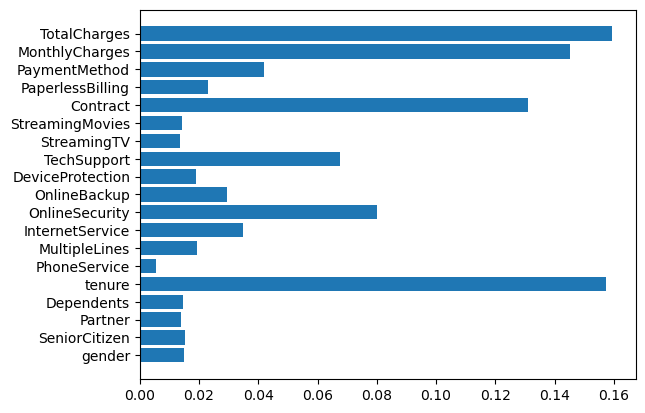

In [90]:
plt.barh(X_train.columns, rf_final.feature_importances_)
plt.show()

We can observe that *TotalCharges*, *MonthlyCharges*, *Contract* and *tenure* variables has the more impact on the Churn status of the customers.

### **5.2. Unsupervised Learning Approach (KMeans)**

In [93]:
# To do

<a id="conclusions-and-recommandations"></a>

## **6. Conclusions and Recommandations**

In [95]:
# To do